In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

%matplotlib inline

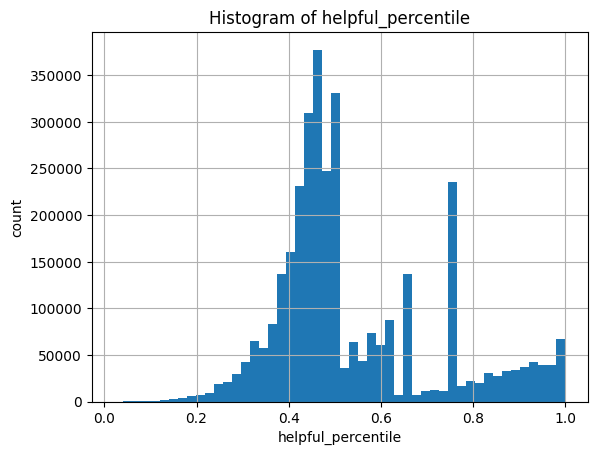

In [20]:
df = pd.read_pickle("df_processed_sentiment.pkl")
df = df.drop(columns=['asin', 'images_meta', 'categories', 'description', 'videos'])
df["helpful_percentile"] = df.groupby("parent_asin")["helpful_vote"].rank(pct=True)
df["is_helpful"] = (df["helpful_percentile"] >= 0.60).astype(int)
cond = (df['helpful_percentile'] == 1.0) & (df['helpful_vote'] < 5)
df = df.loc[~cond].reset_index(drop=True)

ax = df['helpful_percentile'].hist(bins=50)
ax.set_xlabel('helpful_percentile')
ax.set_ylabel('count')
ax.set_title('Histogram of helpful_percentile')
plt.show()


In [21]:
#Select 100000 random samples from the product categories All Beauty, AMAZON FASHION, Appliances and Health & Personal Care
#And get an 50% - 50% split of helpful and not helpful reviews 
df_sampled = pd.DataFrame()
for category in ['All Beauty', 'AMAZON FASHION', 'Appliances', 'Health & Personal Care']:
    df_category = df[df['main_category'] == category]
    df_helpful = df_category[df_category['is_helpful'] == 1].sample(n=100000, replace=True)
    df_not_helpful = df_category[df_category['is_helpful'] == 0].sample(n=100000, replace=True)
    df_sampled = pd.concat([df_sampled, df_helpful, df_not_helpful], ignore_index=True)


In [22]:
df = df_sampled.copy()

In [23]:
print("Is helpful:", len(df_sampled[df_sampled['is_helpful'] == 1]))
print("Is not helpful:", len(df_sampled[df_sampled['is_helpful'] == 0]))

Is helpful: 400000
Is not helpful: 400000


In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["is_helpful"]), df["is_helpful"], test_size=0.3)
dropping_list = ['title_data', 'text', 'helpful_vote', 'title_meta', 'average_rating', 'rating_number', 'features', 'store', 'details', 'helpful_percentile', 'timestamp']
X_train = X_train.drop(columns=dropping_list)
X_test = X_test.drop(columns=dropping_list)
X_train = X_train.drop(columns=['user_id'])
X_test = X_test.drop(columns=['user_id'])

cols = ['parent_asin','main_category', 'sentiment']

# convert to pandas string dtype for both train and test
X_train[cols] = X_train[cols].astype('category')
X_test[cols] = X_test[cols].astype('category')

# verify
X_train[cols].dtypes, X_test[cols].dtypes




(parent_asin      category
 main_category    category
 sentiment        category
 dtype: object,
 parent_asin      category
 main_category    category
 sentiment        category
 dtype: object)

In [25]:
X_train = X_train.drop(columns=['parent_asin'])
X_test = X_test.drop(columns=['parent_asin'])

In [26]:
# One-hot encode main_category and sentiment
X_train = pd.get_dummies(X_train, columns=['main_category', 'sentiment'], drop_first=False)
X_test = pd.get_dummies(X_test, columns=['main_category', 'sentiment'], drop_first=False)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [27]:
def evaluate_model(y_test, y_pred, y_proba):
    """
    Plots the confusion matrix, ROC curve, and prints AUC score.

    Parameters:
    - y_test  : true labels
    - y_pred  : predicted class labels
    - y_proba : predicted probabilities for the positive class
    """

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # --- ROC Curve and AUC ---
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"AUC Score: {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Confusion Matrix:
[[83928 36290]
 [60244 59538]]


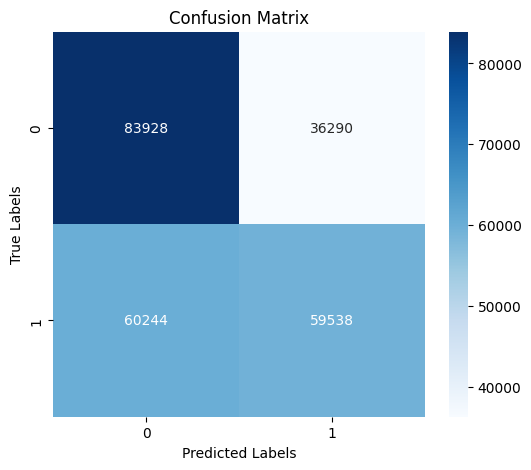

AUC Score: 0.6409


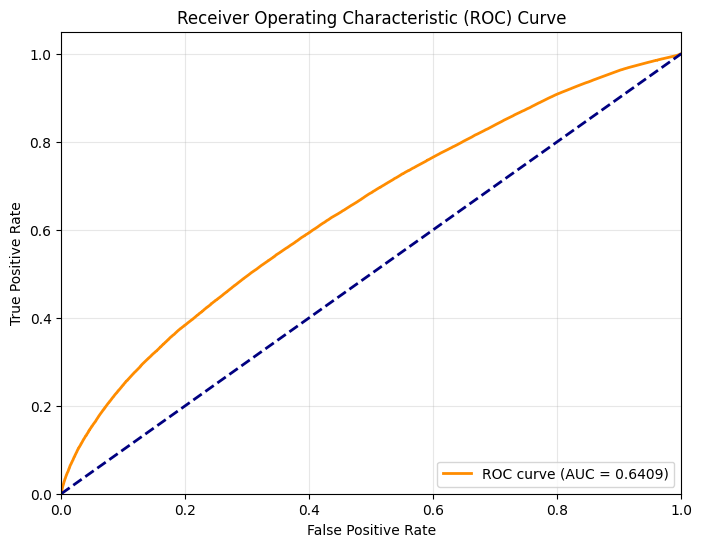

In [28]:
#LR One-Hot encoding

lr_model = LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred, y_proba)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Random Forest Classifier Accuracy: 0.6133625


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s


Confusion Matrix:
[[84392 35826]
 [56967 62815]]


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.6s finished


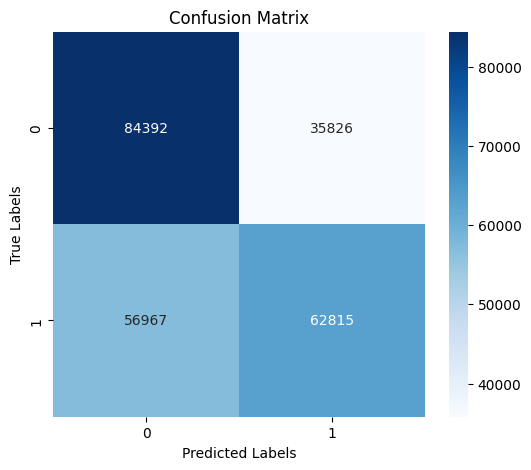

AUC Score: 0.6600


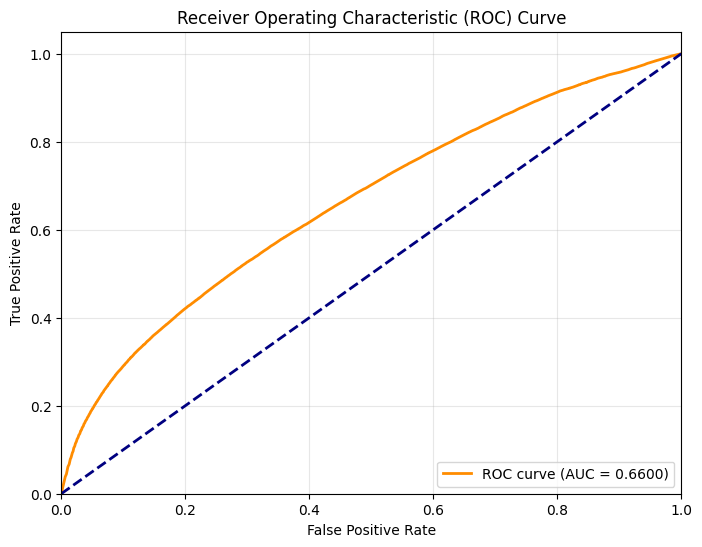

In [29]:
#RF Target Encoding
clf = RandomForestClassifier(n_jobs=-1, verbose=True)
clf.fit(X_train, y_train)

# print score of clf on X_test and y_test
print("Random Forest Classifier Accuracy:", clf.score(X_test, y_test))

# Predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # for ROC/AUC, need probabilities for the positive class

evaluate_model(y_test, y_pred, y_proba)

c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:27:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[83388 36830]
 [57624 62158]]


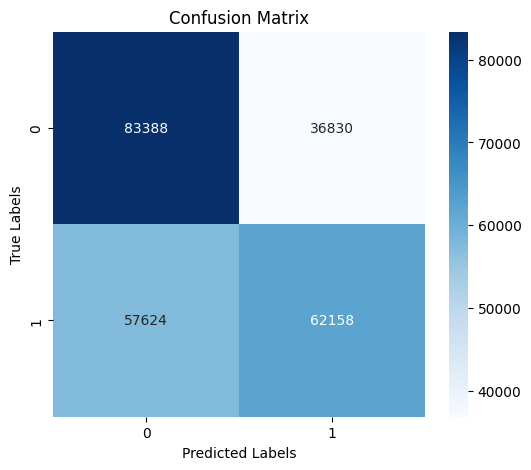

AUC Score: 0.6537


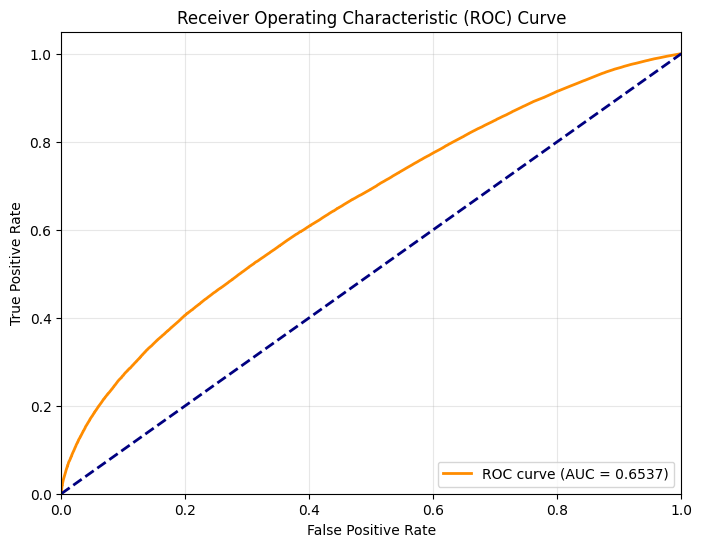

In [30]:
# XGBoost Classifier One-hot encode
n_estimators = 100

model = xgb.XGBClassifier(
    n_estimators=n_estimators,
    tree_method='hist',        # use efficient histogram algorithm
    predictor='auto',          # auto-detect best predictor (GPU if available)
    enable_categorical=True,
    eval_metric='auc',
    verbosity=1,
    n_jobs=-1
    # callbacks=[TQDMProgressBar(total_rounds=n_estimators)]
)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # for ROC/AUC, need probabilities for the positive class

evaluate_model(y_test, y_pred, y_proba)


Iteration 1, loss = 0.66238473
Validation score: 0.594661
Iteration 2, loss = 0.65681807
Validation score: 0.597214
Iteration 3, loss = 0.65458971
Validation score: 0.596964
Iteration 4, loss = 0.65372831
Validation score: 0.599089
Iteration 5, loss = 0.65305472
Validation score: 0.598482
Iteration 6, loss = 0.65286067
Validation score: 0.600679
Iteration 7, loss = 0.65249527
Validation score: 0.601036
Iteration 8, loss = 0.65234284
Validation score: 0.600679
Iteration 9, loss = 0.65225752
Validation score: 0.600446
Iteration 10, loss = 0.65212230
Validation score: 0.600464
Iteration 11, loss = 0.65202487
Validation score: 0.600964
Iteration 12, loss = 0.65195604
Validation score: 0.600393
Iteration 13, loss = 0.65181930
Validation score: 0.601268
Iteration 14, loss = 0.65179646
Validation score: 0.601411
Iteration 15, loss = 0.65171960
Validation score: 0.600518
Iteration 16, loss = 0.65162573
Validation score: 0.601232
Iteration 17, loss = 0.65163117
Validation score: 0.602232
Iterat

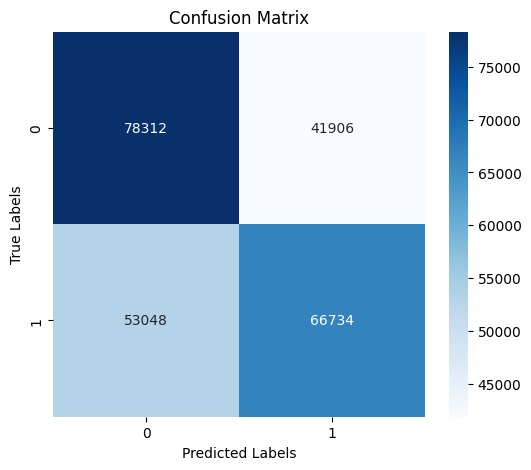

AUC Score: 0.6521


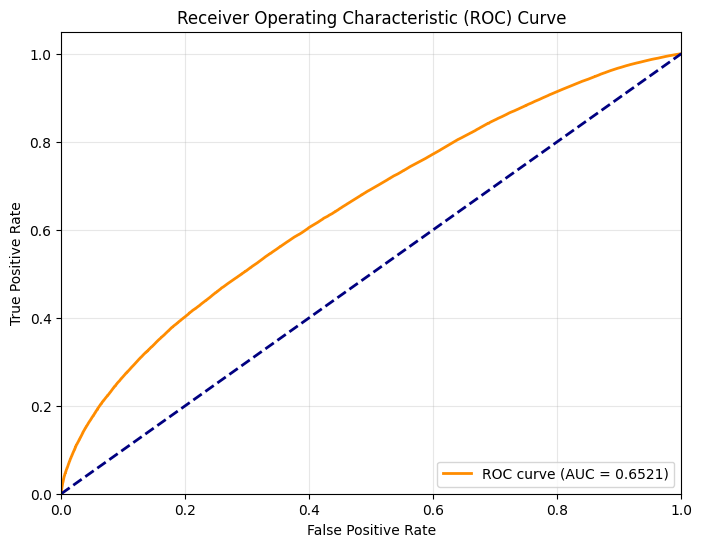

In [31]:
#MLP One-Hot encoding
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50), # Two layers: 100 neurons, then 50 neurons
    max_iter=500,
    activation='relu', # Rectified Linear Unit, a common choice
    solver='adam', # Optimization algorithm
    random_state=42,
    verbose=True,
    early_stopping=True # Stop training if performance on a validation set doesn't improve
)

mlp_model.fit(X_train, y_train)

# --- 4. Evaluation and Prediction (Mirroring your original pattern) ---

# Predictions (class labels: 0 or 1)
y_pred = mlp_model.predict(X_test)

# Probabilities (for ROC/AUC, probabilities for the positive class (1))
y_proba = mlp_model.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred, y_proba)
